# Logistische Regression: Digit Classification

In diesem Notebook wollen wir anhand des Digits-Datensatzes Vorhersagen mit Hilfe einer logistischen Regression machen. In diesem Datensatz ist jeder Datenpunkt ein kleines Bild mit 8x8 Pixeln und stellt eine Ziffer zwischen 0 und 9 dar. Das Vorhersageproblem besteht darin, anhand der 64 Pixelwerte vorherzusagen um welche Zahl es sich handelt.
Eine nähere Beschreibung der Daten findet sich [hier](https://scikit-learn.org/stable/datasets/index.html#digits-dataset).

### Laden des Digits-Datensatzes

Zuerst Laden wir den `Digits`-Datensatz:

In [1]:
import pandas as pd
data = pd.read_csv("data/digits.csv")
print(data.shape)
data.head()

(1797, 65)


,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


Ein Datenpunkt hat 64 Features. Jedes Feature steht für ein Pixel in einem 8x8 Bild und hat einen Wert zwischen `0` und `16`, welcher der Graustufe des Pixels entspricht. Für den Wert `0` ist das Pixel komplett schwarz, während ein Wert von `16` einem weißen Pixel entspricht. Das Label eines Datenpunkts ist die abgebildete Ziffer.

Die ersten 8 Features entsprechen den Pixeln der ersten Reihe des Bildes, die zweiten 8 Features der zweiten Reihe des Bildes usw.
Um das besser zu veranschaulichen können wir die Daten des ersten Datenpunktes in eine 8x8-Form bringen:

In [2]:
import numpy as np
data_no_label = data.drop(["label"], axis=1)
line_1 = data_no_label.iloc[0].values
np.reshape(line_1, (8,8))

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Um uns testweise ein paar Bilder anzuschauen können wir ein paar zufällig ausgewählte Datenpunkte mit Hilfe der `matplotlib`-Library plotten:

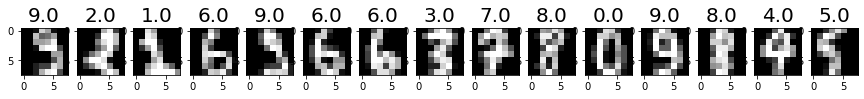

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import random

no_images = 15

plt.figure(figsize=(no_images, 1))
for index in range(0, no_images):
    
    # wähle zufälligen Datenpunkt aus
    image_index = random.randint(0, data.shape[0])
    features = data_no_label.iloc[image_index].values
    features_8x8 = np.reshape(features, (8,8))
    label = data.iloc[image_index]["label"]
    
    # plotte das 8x8 Bild
    plt.subplot(1, no_images, index + 1)
    plt.imshow(features_8x8, cmap=plt.cm.gray)
    plt.title(label, fontsize = 20)

### Binäre Klassifikation

Ziel ist es jetzt mit Hilfe der Features (Pixelwerte) das Label (die dargestellte Ziffer) vorherzusagen. Dazu wollen wir uns im ersten Schritt auf eine einfache binäre Klassifizierung beschränken und Vorhersagen ob auf dem Bild die Ziffer `0` zu sehen ist.

Im ersten Schritt unterteilen wir die Daten in Trainings- und Testdaten:

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_no_label, data["label"], test_size=0.2, random_state=0)
print("Trainingsdatenpunkte:", len(X_train))
print("Testdatenpunkte:", len(X_test))

Trainingsdatenpunkte: 1437
Testdatenpunkte: 360


Für die Klassifierzung hinsichtlich der Ziffer `0` müssen wir das Label jedes Datenpunktes umwandeln, so dass gilt:
- `Label "1"`: Die Ziffer ist eine `0`.
- `Label "0"`: Die Ziffer ist keine `0` (d.h. alle andere Ziffern).

Diese machen wir über folgende Funktion:

In [5]:
def label_to_binary(digit, labels):
    binary_labels = []
    for label in labels:
        if(label == digit):
            binary_labels.append(1)
        else:
            binary_labels.append(0)
    return np.array(binary_labels)
    
y_train_0 = label_to_binary(0, y_train)
y_test_0 = label_to_binary(0, y_test)

print("Alte Labels:", y_train[:20].values)
print("Neue Labels:", y_train_0[:20])

Alte Labels: [6 5 3 4 4 4 8 8 7 0 9 6 3 5 2 3 0 8 3 3]
Neue Labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]


Jetzt können wir das logistische Regressionsmodell trainieren.

In [6]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(max_iter=1000) # Gradient Descent mit max. 1000 Schritten
logisticRegr.fit(X_train, y_train_0)

LogisticRegression(max_iter=1000)

### Testen des Regressionsmodells

Schauen wir uns nun zwei Beispiele aus den Testdaten und die dazugehörige Vorhersage an:

In [7]:
X_test

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
1081,0.0,0.0,11.0,16.0,15.0,3.0,0.0,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,13.0,13.0,8.0,13.0,16.0,8.0
1707,0.0,1.0,15.0,14.0,2.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,1.0,15.0,16.0,12.0,1.0,0.0,0.0
927,0.0,2.0,13.0,16.0,10.0,0.0,0.0,0.0,0.0,12.0,...,6.0,0.0,0.0,1.0,13.0,16.0,16.0,16.0,16.0,3.0
713,0.0,0.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,7.0,14.0,16.0,12.0,1.0,0.0
262,0.0,0.0,3.0,13.0,6.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,3.0,13.0,15.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,0.0,0.0,3.0,8.0,11.0,13.0,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,12.0,13.0,2.0,0.0,0.0
557,0.0,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,7.0,0.0,0.0,0.0
1730,0.0,1.0,9.0,16.0,16.0,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,16.0,11.0,4.0,0.0,0.0
638,0.0,0.0,0.0,3.0,14.0,13.0,3.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,3.0,13.0,15.0,2.0,0.0


In [8]:
data_index = 0
data_point = X_test.iloc[data_index]
prediction = logisticRegr.predict([data_point])
print("Vorhersage auf Datenpunkt", data_index, "ist:", prediction)

Vorhersage auf Datenpunkt 0 ist: [0]


Das Modell sagt die Klasse `0` vorraus (d.h. dass nicht die Ziffer 0 abgebildet ist). Schauen wir uns das richtige Label und den zugehörigen Plot an.

Text(0.5, 1.0, 'Ziffer: 2')

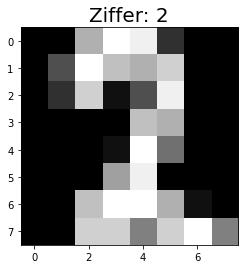

In [9]:
plt.plot()
plt.imshow(np.reshape(data_point.values, (8,8)), cmap=plt.cm.gray)
plt.title(f'Ziffer: {y_test.iloc[data_index]}', fontsize = 20)

Die Vorhersage ist richtig (es ist nicht die Ziffer 0 auf dem Bild dargestellt).
Schauen wir uns ein zweites Beispiel an.

In [10]:
data_index = 17
data_point = X_test.iloc[data_index]
prediction = logisticRegr.predict([data_point])
print("Vorhersage auf Datenpunkt", data_index, "ist:", prediction)

Vorhersage auf Datenpunkt 17 ist: [1]


Text(0.5, 1.0, 'Ziffer: 0')

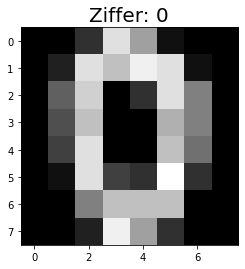

In [11]:
plt.plot()
plt.imshow(np.reshape(data_point.values, (8,8)), cmap=plt.cm.gray)
plt.title(f"Ziffer: {y_test.iloc[data_index]}", fontsize = 20)

In diesem Fall sagt das Modell die Klasse `1` (= es ist eine Null auf dem Bild zu sehen) voraus und es ist auch tatsächlich eine `0` auf dem Bild, d.h. das Modell liegt richtig. 

Schauen wir uns die Performance auf allen Testdaten an. Dazu mache wir zuerst eine Vorhersage mit dem Modell auf allen Testdaten:

In [12]:
predictions = logisticRegr.predict(X_test)

Im nächsten Schritt vergleich wir diese Vorhersagen mit dem wahren Label und berechnen die Accuracy:

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_0, predictions)

0.9944444444444445

Die Accuracy liegt bei diesem einfachen Modell bei 99 Prozent. Schauen wir uns Precision und Recall an.

In [14]:
from sklearn.metrics import precision_score
precision_score(y_test_0, predictions)

0.9310344827586207

In [15]:
from sklearn.metrics import recall_score
recall_score(y_test_0, predictions)

1.0

Das Modell erkennt alle Nullen im Testdatensatz und ist dabei 93% präzise.
Es scheint also, dass das Problem eine Null in diesem Datensatz zu erkennen nicht sehr schwierig ist.

Da wir jedoch keine 100% Precision erreicht haben, macht das Modell noch ein paar Fehler. Schauen wir uns exemplarisch einen Fehler an:

In [16]:
data_index = 117
data_point = X_test.iloc[data_index]
prediction = logisticRegr.predict([data_point])
print("Vorhersage auf Datenpunkt", data_index, "ist:", prediction)

Vorhersage auf Datenpunkt 117 ist: [1]


Text(0.5, 1.0, 'Ziffer: 2')

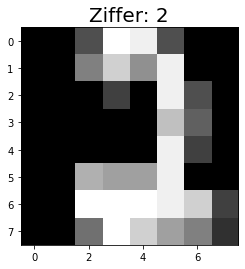

In [17]:
plt.plot()
plt.imshow(np.reshape(data_point.values, (8,8)), cmap=plt.cm.gray)
plt.title("Ziffer: " + str(y_test.iloc[data_index]), fontsize = 20)

Dieses Zwei hält das Modell fälschlicherweiße für eine Null.

### Feature Importance

Beim gerade trainierten Modell können wir uns jetzt noch die Feature-Importance anschauen, d.h. die Gewichte welche das Modell für die einzelnen Pixel gelernt hat anschauen.

In [18]:
weights = logisticRegr.coef_[0]

In [19]:
weights_8x8 = np.round(np.reshape(weights, (8,8)), decimals=3)
weights_8x8

array([[ 0.   , -0.027, -0.041,  0.112, -0.034, -0.256, -0.225, -0.023],
       [-0.   , -0.088, -0.043,  0.265,  0.195,  0.304, -0.008, -0.017],
       [ 0.   ,  0.12 ,  0.161, -0.083, -0.353,  0.287,  0.05 , -0.006],
       [-0.   ,  0.084, -0.008, -0.162, -0.57 ,  0.055,  0.056, -0.001],
       [ 0.   ,  0.131,  0.108, -0.116, -0.581,  0.073,  0.   ,  0.   ],
       [-0.002, -0.033,  0.273, -0.312, -0.181,  0.022,  0.126, -0.   ],
       [-0.005, -0.068,  0.078,  0.014,  0.087,  0.061, -0.04 , -0.013],
       [ 0.   , -0.032, -0.202,  0.226, -0.279, -0.122, -0.083, -0.063]])

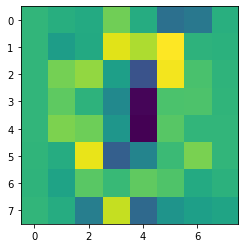

In [20]:
plt.imshow(weights_8x8)

In diesem Plot stehen grüne Fläche für ein Gewicht in der Nähe von 0, d.h. diese Pixel sind relativ irrelevant für die Klassifikation des Modells.
Gelbe Flächen stehen für positive Gewichte, d.h. ein positiver Pixelwert an dieser Stelle lässt das Modell eher in Richtung 0 tendieren.
Dunkle Flächen stehen für negative Gewichte, d.h. ein positiver Pixelwert an dieser Stelle lässt das Modell eher in Richting "keine 0" tendieren. 

### Multiklassen-Klassifikation

Im nächsten Schritt erweitern wir das Vorhersagemodell dahingehend, dass wir alle Ziffern erkennen wollen. Dies geschieht mit einer multinominalen logistischen Regression.

Dazu trainieren wir individuelle Modell für jede Ziffer von 0 bis 9.

In [21]:
models = []
for i in range(0,10):
    logisticRegr = LogisticRegression(max_iter=1000)
    y_train_binary = label_to_binary(i, y_train)
    logisticRegr.fit(X_train, y_train_binary)
    models.append(logisticRegr)

Diese Modell nutzen wir jetzt bei der Vorhersage, in dem wir mit jedem Modell eine Vorhersage auf ein gegebens Bild machen und uns für die Vorhersage mit der höchsten Wahrscheinlichkeit entscheiden. Dazu brauchen wir (anstelle der vorhergesagten Klasse) die Vorhersagewahrscheinlichkeit eines Modells. Generell können wir mit der Methode `predict` direkt die Vorhersage der Klasse bekommen, während die `predict_proba`-Methode uns die Wahrscheinlichkeiten liefert:

In [22]:
data_point = X_test.iloc[0]
predicted_class = logisticRegr.predict([data_point])
print("Vorhergesagte Klasse:", predicted_class)

probability = logisticRegr.predict_proba([data_point])
print(probability)
print("Wahrscheinlichkeit für Klasse 1:", probability[0][1])

Vorhergesagte Klasse: [0]
[[9.99999999e-01 8.23550869e-10]]
Wahrscheinlichkeit für Klasse 1: 8.235508686129629e-10


Mit den trainierten Einzelmodellen können wir nun für einen Datenpunkt vorhersagen mit allen 10 Modell machen:

In [23]:
data_index = 34
predictions = []
for index, model in enumerate(models):
    data_point = X_test.iloc[data_index]
    prediction = model.predict_proba([data_point])[0][1]
    print("Vorhersage mit Modell für Ziffer", index, "ist", prediction)
    predictions.append(prediction)

Vorhersage mit Modell für Ziffer 0 ist 0.001207936029629041
Vorhersage mit Modell für Ziffer 1 ist 1.8026516772177994e-10
Vorhersage mit Modell für Ziffer 2 ist 3.3103326514604146e-07
Vorhersage mit Modell für Ziffer 3 ist 1.0386544124234156e-06
Vorhersage mit Modell für Ziffer 4 ist 6.5531148594170136e-12
Vorhersage mit Modell für Ziffer 5 ist 1.1396704562691808e-06
Vorhersage mit Modell für Ziffer 6 ist 1.2920281791923125e-15
Vorhersage mit Modell für Ziffer 7 ist 2.0489972040191095e-09
Vorhersage mit Modell für Ziffer 8 ist 0.04631588281239819
Vorhersage mit Modell für Ziffer 9 ist 0.9999999947374436


Und die Klasse vorhersagen welche die höchste Wahrscheinlichkeit hat:

In [24]:
prediction = predictions.index(max(predictions))
print("Vorhergesagte Klasse:", prediction)

Vorhergesagte Klasse: 9


Text(0.5, 1.0, 'Ziffer: 9')

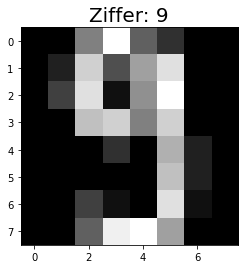

In [25]:
plt.plot()
plt.imshow(np.reshape(X_test.iloc[data_index].values, (8,8)), cmap=plt.cm.gray)
plt.title(f"Ziffer: {y_test.iloc[data_index]}", fontsize = 20)

Wie wir sehen stimmt die vorhergesagte Ziffer in diesem Fall mit der tatsächlichen Ziffer überein. Im nächsten Schritt schauen wir uns die Vorhersage über alle Testdatenpunkte an und schauen auf die Accuarcy.
Dazu sagen wir mit jedem der 10 Modelle auf jedem Testdatenpunkt vorher, und merken uns die Klasse mit der höchsten Wahrscheinlichkeit:

In [26]:
X_test

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
1081,0.0,0.0,11.0,16.0,15.0,3.0,0.0,0.0,0.0,5.0,...,1.0,0.0,0.0,0.0,13.0,13.0,8.0,13.0,16.0,8.0
1707,0.0,1.0,15.0,14.0,2.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,1.0,15.0,16.0,12.0,1.0,0.0,0.0
927,0.0,2.0,13.0,16.0,10.0,0.0,0.0,0.0,0.0,12.0,...,6.0,0.0,0.0,1.0,13.0,16.0,16.0,16.0,16.0,3.0
713,0.0,0.0,9.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,7.0,14.0,16.0,12.0,1.0,0.0
262,0.0,0.0,3.0,13.0,6.0,0.0,0.0,0.0,0.0,0.0,...,11.0,0.0,0.0,0.0,3.0,13.0,15.0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,0.0,0.0,3.0,8.0,11.0,13.0,14.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,2.0,12.0,13.0,2.0,0.0,0.0
557,0.0,0.0,0.0,9.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,7.0,0.0,0.0,0.0
1730,0.0,1.0,9.0,16.0,16.0,12.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,16.0,11.0,4.0,0.0,0.0
638,0.0,0.0,0.0,3.0,14.0,13.0,3.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,3.0,13.0,15.0,2.0,0.0


In [27]:
test_predictions = []
for data_point in X_test.values:
    predictions = []
    for model in models:  
        prediction = model.predict_proba([data_point])[0][1]
        predictions.append(prediction)
    predicted_class = predictions.index(max(predictions))
    test_predictions.append(predicted_class)

In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predictions)

0.9472222222222222

Wie wir sehen können wir mit unserem recht simplen Modell bereits 95% der Fälle richtig vorhersagen.

Zum Schluss schauen wir uns die Confusion Matrix der einzelnen Fälle an und den Classificatin Report:

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
confusion_matrix(y_test, test_predictions, labels=range(0,10))

array([[27,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 31,  0,  0,  0,  0,  1,  0,  3,  0],
       [ 0,  0, 34,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 28,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 30,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 39,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0,  0, 43,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0, 37,  0,  0],
       [ 0,  3,  1,  0,  0,  0,  0,  0, 34,  1],
       [ 0,  0,  0,  1,  0,  1,  0,  0,  1, 38]])

In [30]:
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.89      0.89      0.89        35
           2       0.97      0.94      0.96        36
           3       0.90      0.97      0.93        29
           4       0.94      1.00      0.97        30
           5       0.95      0.97      0.96        40
           6       0.98      0.98      0.98        44
           7       1.00      0.95      0.97        39
           8       0.89      0.87      0.88        39
           9       0.95      0.93      0.94        41

    accuracy                           0.95       360
   macro avg       0.95      0.95      0.95       360
weighted avg       0.95      0.95      0.95       360

